### 二次元リストから生成

In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

import pandas as pd

# 1 各行を一つのリストとして並べる

list = [
    [1, 100, 0.33, 'AAA', 'AAA100'], 
    [2, 200, 0.67, 'BBB', 'BBB200'], 
    [3, 300, 1, 'CCC', 'CCC300'], 
    [4, 400, 1.33, 'DDD', 'DDD400'], 
    [5, 500, 1.67, 'EEE', 'EEE500'], 
    [6, 600, 2, 'FFF', 'FFF600']
]

# 2 表に変換
# pd.DataFrame(list) : pandasのDataFrameで表に変換
df = pd.DataFrame(list)
# 行名・列名は自動で割り振られた番号になっている

# 3 行名の変更
df.index = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']

# 4 列名の変更
df.columns = ['col0', 'col1', 'col2', 'col3', 'col4']

df

# 1 各行を一つのリストとして並べる
list = [
[1, 100, 0.33, 'AAA', 'AAA100'], 
[2, 200, 0.67, 'BBB', 'BBB200'], 
[3, 300, 1, 'CCC', 'CCC300'], 
[4, 400, 1.33, 'DDD', 'DDD400'], 
[5, 500, 1.67, 'EEE', 'EEE500'], 
[6, 600, 2, 'FFF', 'FFF600']]


#2 表に変換(オプションで行列名を指定)
ind = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']
col = ['col0', 'col1', 'col2', 'col3', 'col4']

df = pd.DataFrame(list, index=ind, columns=col)


df

# 1 各行を一つのリストにする
list = [
['row0', 1, 100, 0.33, 'AAA', 'AAA100'], 
['row1', 2, 200, 0.67, 'BBB', 'BBB200'], 
['row2', 3, 300, 1, 'CCC', 'CCC300'], 
['row3', 4, 400, 1.33, 'DDD', 'DDD400'], 
['row4', 5, 500, 1.67, 'EEE', 'EEE500'], 
['row5', 6, 600, 2, 'FFF', 'FFF600'], ]

# 2 表に変換
df = pd.DataFrame(list)

# 3 列名を変更
df.columns = ['', 'col0', 'col1', 'col2', 'col3', 'col4']

# 4 行名となる列を指定
df = df.set_index('')

df

# 1 各行ごとのリストを作成

listA = [1, 100, 0.33, 'AAA', 'AAA100']
listB = [2, 200, 0.67, 'BBB', 'BBB200']
listC = [3, 300, 1, 'CCC', 'CCC300']
listD = [4, 400, 1.33, 'DDD', 'DDD400']
listE = [5, 500, 1.67, 'EEE', 'EEE500']
listF = [6, 600, 2, 'FFF', 'FFF600']

# 2 まとめて表に変換

df = pd.DataFrame([listA, listB, listC, listD, listE, listF])

# 3 行名の変更
df.index = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']

# 4 列名の変更
df.columns = ['col0', 'col1', 'col2', 'col3', 'col4']

del list

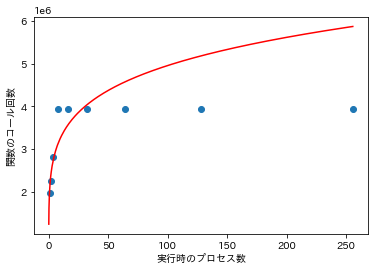

In [2]:
cg_c_data = return_dict_summary_fixed()

x = cg_c_data["processes"]
y = cg_c_data["ICNVRT"]

cg_icnvrt_lr = ModelLog10(x, y, "CG", "ICNVRT")

cg_icnvrt_lr.calc_lr()

cg_icnvrt_lr.plot_graph()

In [3]:
max_in_y = max(y)
# 最大値の個数を取得
y.tolist().count(max_in_y)
# 最大値のインデックスで最小のもの
y.tolist().index(max_in_y)

3

0.0


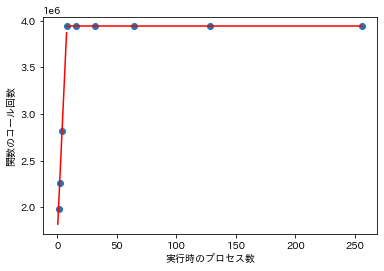

In [4]:
model_branch = ModelBranch(x, y, "CG", "ICNVRT")

model_branch.calc_lr()

model_branch.calc_mape_score()

print(model_branch.mape_score)

model_branch.plot_graph()

In [5]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

In [6]:
# 変数：test_ratios
# テスト用データとする割合のリスト
test_ratios = [0.3, 0.4, 0.5, 0.6, 0.7]

for test_ratio in test_ratios:
    print(f"test_ratio={test_ratio}")
    print(f"train_list, test_list = {split_by_ratio(processes_excludeBTSP, test_ratio)} on processes_excludeBTSP")
    print(f"train_list, test_list = {split_by_ratio(processes_onlyBTSP, test_ratio)} on processes_onlyBTSP")
    print(f"\n")
    fixed_class_list = [0] * len(benchmarks)
    for i in range(len(fixed_class_list)):
        if ( benchmarks[i] == "bt" or benchmarks[i] == "sp" ):
            processes = processes_onlyBTSP
        else:
            processes = processes_excludeBTSP
        fixed_class_list[i] = return_fixed_class(BenchMark = benchmarks[i], Processes = processes, FixedBenchMarkClass = "C")

        print(f"type(fixed_class_list) = {type(fixed_class_list)}")

    fixed_class_DataFrame = [0] * len(fixed_class_list)
    for i in range(len(fixed_class_list)):
        fixed_class_DataFrame[i] = pd.concat(fixed_class_list[i] , axis=1)

    # テーブルの元となるDataFrameを作成する
    MapeTable_source = [0] * len(fixed_class_list)
    for i in range(len(fixed_class_list)):
        dict_data = return_dict_Data(fixed_class_DataFrame[i])
        MapeTable_per_benchmark = return_MapeTable_per_benchmark(dict_data, test_ratio=test_ratio)
        MapeTable_row = return_MapeTable_row(MapeTable_per_benchmark, benchmarks[i], f"TestRatio{test_ratio}_FixedClass")
        MapeTable_source[i] = MapeTable_row
    # テーブルの元となるDataFrameにつける列名のリスト
    MapeTable_source_column_name = ["線形モデル", "対数モデル", "反比例モデル", "分岐モデル", "ベンチマーク名"]
    MapeTable = pd.DataFrame(MapeTable_source)
    MapeTable.columns = MapeTable_source_column_name
    MapeTable = MapeTable.set_index('ベンチマーク名')
    # テーブルを欲しい形でCSVとして出力する
    save_MapeTable(MapeTable, suffix=f"FixedClass{test_ratio}")


test_ratio=0.3
train_list, test_list = ([1, 2, 4, 8, 16, 32, 64], [128, 256]) on processes_excludeBTSP
train_list, test_list = ([1, 4, 9, 16, 25, 36, 49, 64, 81, 100], [121, 169, 196, 225]) on processes_onlyBTSP


type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
test_ratio=0.4
train_list, test_list = ([1, 2, 4, 8, 16, 32], [64, 128, 256]) on processes_excludeBTSP
train_list, test_list = ([1, 4, 9, 16, 25, 36, 49, 64, 81], [100, 121, 169, 196, 225]) on processes_onlyBTSP


type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_class_list) = <class 'list'>
type(fixed_c

In [7]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

In [8]:
BenchmarkClasses = ["A", "B", "C", "D"]
BenchmarkClasses_on_num = [1, 4, 16, 256]
test_ratios = [0.3, 0.5, 0.8]


for test_ratio in test_ratios:
    print(f"test_ratio={test_ratio}")
    print(f"train_list, test_list = {split_by_ratio(BenchmarkClasses, test_ratio)} on BenchmarkClasses")
    print(f"train_list, test_list = {split_by_ratio(BenchmarkClasses_on_num, test_ratio)} on BenchmarkClasses_on_num")
    fixed_process_list = [0] * len(benchmarks)
    for i in range(len(benchmarks)):
        fixed_process_list[i] = return_fixed_process(BenchMark=benchmarks[1], BenchMarkClasses=BenchmarkClasses, FixedProcess=32)

    fixed_process_DataFrame = [0] * len(benchmarks)
    for i in range(len(benchmarks)):
        fixed_process_DataFrame[i] = pd.concat(fixed_process_list[i], axis=1)

    # テーブルの元となるDataFrameを作成する
    MapeTable_source = [0] * len(fixed_process_list)
    for i in range(len(fixed_process_list)):
        dict_data = return_dict_Data(fixed_process_DataFrame[i])
        dict_data['rowData'] = BenchmarkClasses_on_num
        MapeTable_per_benchmark = return_MapeTable_per_benchmark(dict_data, test_ratio=test_ratio)
        MapeTable_row = return_MapeTable_row(MapeTable_per_benchmark, benchmarks[i], f"TestRatio{test_ratio}_FixedProcess")
        MapeTable_source[i] = MapeTable_row
    # テーブルの元となるDataFrameにつける列名のリスト
    MapeTable_source_column_name = ["線形モデル", "対数モデル", "反比例モデル", "分岐モデル", "ベンチマーク名"]
    MapeTable = pd.DataFrame(MapeTable_source)
    MapeTable.columns = MapeTable_source_column_name
    MapeTable = MapeTable.set_index('ベンチマーク名')
    # テーブルを欲しい形でCSVとして出力する
    save_MapeTable(MapeTable, suffix=f"FixedProcess{test_ratio}")



test_ratio=0.3
train_list, test_list = (['A', 'B', 'C'], ['D']) on BenchmarkClasses
train_list, test_list = ([1, 4, 16], [256]) on BenchmarkClasses_on_num
test_ratio=0.5
train_list, test_list = (['A', 'B'], ['C', 'D']) on BenchmarkClasses
train_list, test_list = ([1, 4], [16, 256]) on BenchmarkClasses_on_num
test_ratio=0.8
train_list, test_list = (['A'], ['B', 'C', 'D']) on BenchmarkClasses
train_list, test_list = ([1], [4, 16, 256]) on BenchmarkClasses_on_num
